# Exploration
--------------
In diesem Notebook wird eine erste Analyse bezüglich der vorliegenden Daten gemacht.
Dabei ist es das Ziel, für unsere Fragestellung relevante Daten zu extrapolieren, und festzustellen,
welche Spalten einen Einfluss auf vergangene Wahlergebnisse hatten. Ein weiteres zentrales Thema dieser ersten Untersuchung
ist es, aus den gewonnenen Erkenntnissen Hypothesen zu formulieren, welche wir nach einer weiteren aber genauer verlaufenden
Analyse zu falsifizieren oder verifizieren versuchen.

## Import der Libraries
Folgende Libraries werden genutzt:

In [14]:
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


## 1. Daten einlesen und erste Analyse

In [4]:
# CSV-Datei einlesen – wir verwenden Semikolon als Trennzeichen und UTF-8 Kodierung
df = pd.read_csv('Data/dataset.csv', delimiter=";", encoding="utf-8")

# Erste Zeilen des Datensatzes anzeigen, um einen Überblick zu bekommen
print("Erste 5 Zeilen:")
print(df.head())
# Strukturinformationen des DataFrames ausgeben (Spaltentypen, fehlende Werte, etc.)
print("\nInfo zum DataFrame:")
df.info()
# Deskriptive Statistik berechnen (Mittelwert, Standardabweichung, Min/Max, etc.)
print("\nDeskriptive Statistik:")
print(df.describe())

Erste 5 Zeilen:
   anr       datum                                       titel_kurz_d  \
0  1.0  12.09.1848  Bundesverfassung der schweizerischen Eidgenoss...   
1  2.0  14.01.1866                                   Mass und Gewicht   
2  3.0  14.01.1866  Gleichstellung der Juden und Naturalisierten m...   
3  4.0  14.01.1866  Stimmrecht der Niedergelassenen in Gemeindeang...   
4  5.0  14.01.1866  Besteuerung und zivilrechtliche Verhältnisse d...   

                                        titel_kurz_f  \
0   Constitution fédérale de la Confédération suisse   
1                                   Poids et mesures   
2                                  Egalité des Juifs   
3  Droit de vote des Suisses établis, en matière ...   
4      Impôts et rapports civils des Suisses établis   

                                        titel_kurz_e  \
0    Federal Constitution of the Swiss Confederation   
1                               Weights and measures   
2  Equal rights for Jews and naturalised

## 2. Filtern und Bereinigen der Daten

In [5]:
# Selektiere nur die Spalten, die "-annahme" enthalten (Abstimmungsergebnisse pro Kanton)
df_filtered = df[[col for col in df.columns if '-annahme' in col]]

# Problematische Werte ersetzen:
# - '.' und 'z' werden als fehlende Werte (NaN) interpretiert
# - '1' bedeutet Annahme der Vorlage
# - '0' bedeutet Ablehnung der Vorlage
df_filtered = df_filtered.replace({'.': np.nan, 'z': np.nan, '1': 1, '0': 0})
# Alle Werte in numerisches Format umwandeln; nicht-konvertierbare werden zu NaN
df_filtered = df_filtered.apply(pd.to_numeric, errors='coerce')

## 3. Visualisierungen: Gestapeltes Balkendiagramm

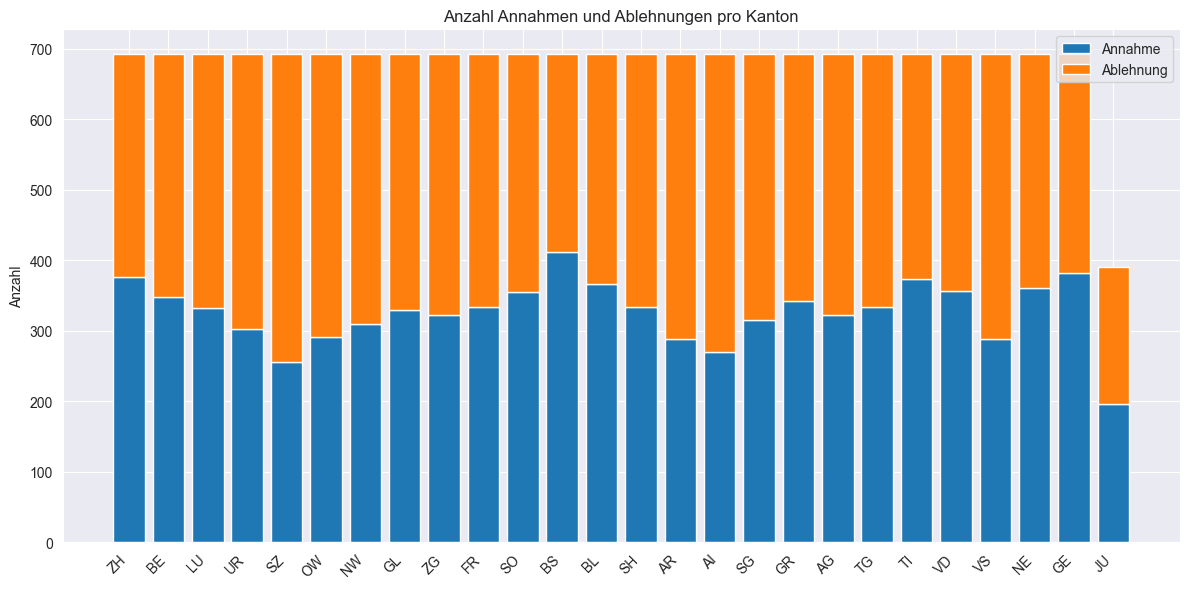

In [6]:
# Berechnung der Anzahl Annahmen und Ablehnungen pro Kanton
acceptance_counts = (df_filtered == 1).sum()  # Summe aller Annahmen
rejected_counts = (df_filtered == 0).sum()    # Summe aller Ablehnungen

# Formatiere die Kantonsnamen für die Visualisierung
# Ersetze "-annahme" und wandle in Großbuchstaben um (z.B. "zh-annahme" wird zu "ZH")
canton_names = acceptance_counts.index.str.replace("-annahme", "", regex=False).str.upper()

# Erstelle ein gestapeltes Balkendiagramm für Annahmen und Ablehnungen pro Kanton
fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(canton_names, acceptance_counts.values, label='Annahme', color='tab:blue')
ax.bar(canton_names, rejected_counts.values, bottom=acceptance_counts.values, label='Ablehnung', color='tab:orange')

plt.xticks(rotation=45, ha='right')  # Drehe Beschriftungen für bessere Lesbarkeit
plt.title('Anzahl Annahmen und Ablehnungen pro Kanton')
plt.ylabel('Anzahl')
plt.legend()
plt.tight_layout()
plt.show()

## 4. Erweiterte Analyse: Annahmequote pro Kanton

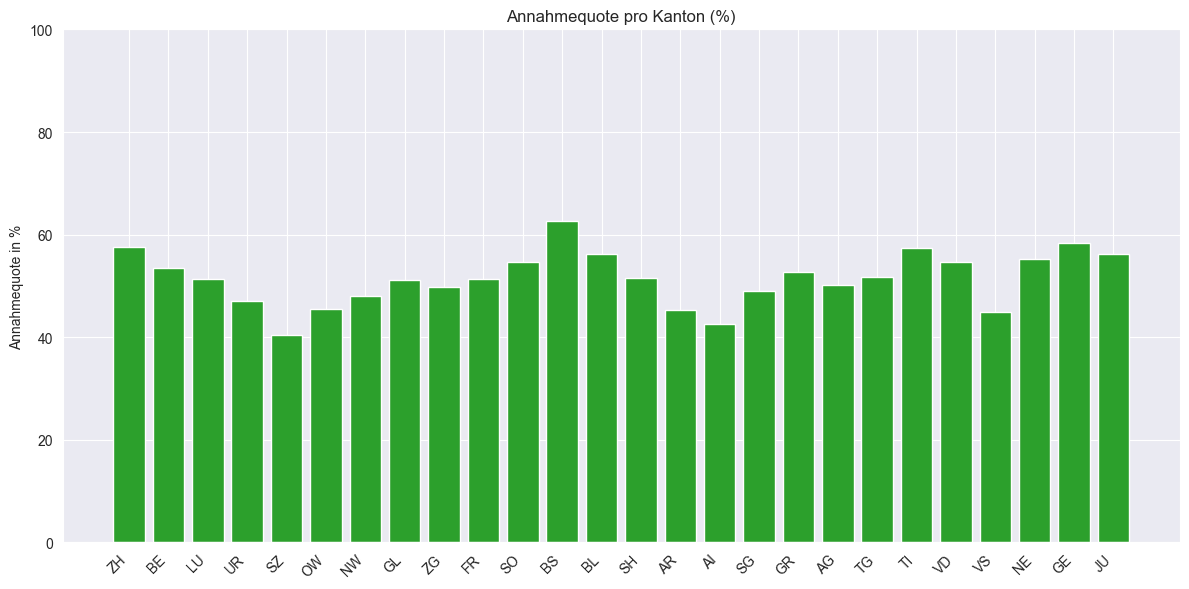

In [7]:
## 4. Erweiterte Analyse: Annahmequote pro Kanton
# Berechne die durchschnittliche Annahmequote pro Kanton
# Da die Werte 0 und 1 sind, gibt der Mittelwert direkt den Anteil der Annahmen an
acceptance_rate = df_filtered.mean()

# Visualisierung der Annahmequote als Prozentsatz in einem Balkendiagramm
fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(canton_names, acceptance_rate.values * 100, color='tab:green')  # Umrechnung in Prozent
plt.xticks(rotation=45, ha='right')
plt.title('Annahmequote pro Kanton (%)')
plt.ylabel('Annahmequote in %')
plt.ylim(0, 100)  # Y-Achse von 0 bis 100%
plt.tight_layout()
plt.show()

## 5. Erweiterte Analyse: Korrelationsmatrix zwischen Kantonen


### Korrelationsmatrix der Abstimmungsergebnisse pro Kanton

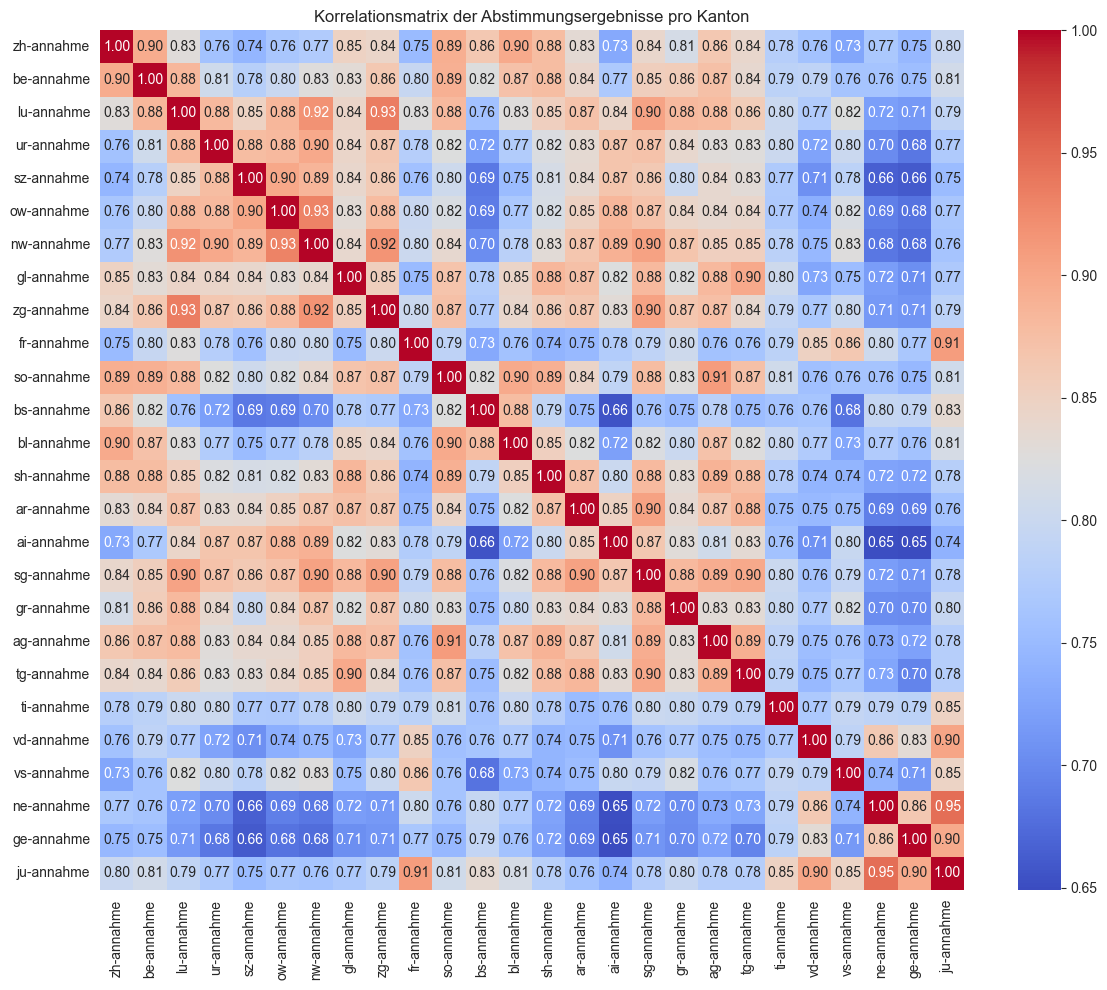

In [8]:
# Berechne Korrelationen zwischen Kantonen, um zu sehen, ob sie ähnlich abstimmen
# Positive Korrelation bedeutet, dass Kantone tendenziell ähnlich abstimmen
corr_matrix = df_filtered.corr()

# Visualisierung der Korrelationsmatrix als Heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Korrelationsmatrix der Abstimmungsergebnisse pro Kanton")
plt.tight_layout()
plt.show()

### Korrelationsmatrix der Abstimmungsergebnisse pro Kanton vor 1971

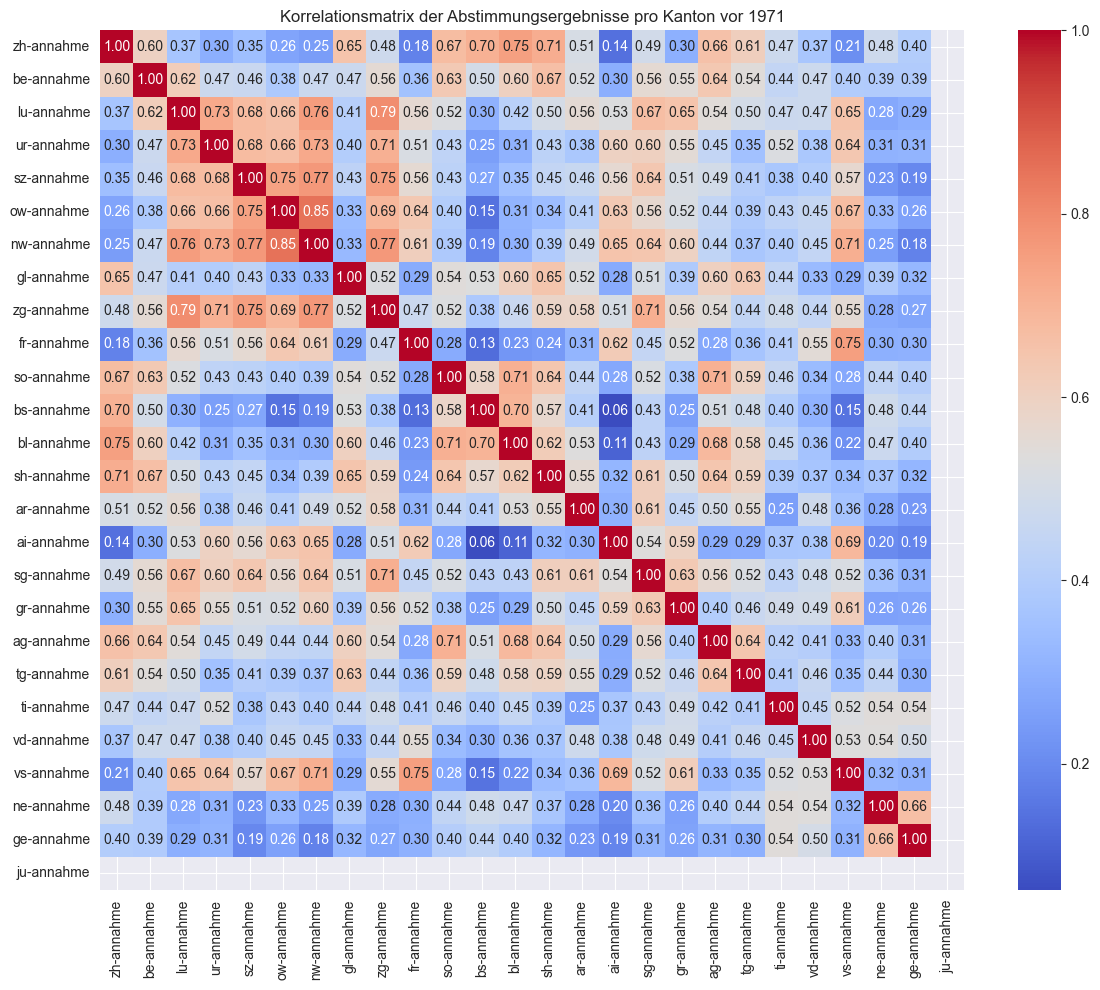

In [9]:
# Definiere das Datum für die Einführung des Frauenstimmrechts in der Schweiz
init_date = datetime(1971, 2, 7, 0, 0)

# Teile die Daten in Abstimmungen vor und nach der Einführung des Frauenstimmrechts
# Abstimmungen vor 1971 (ohne Frauenstimmrecht)
df_without_women = df_filtered.loc[pd.to_datetime(df['datum'], format='%d.%m.%Y') < init_date]
df_without_women.reset_index(drop=True, inplace=True)

# Berechne und visualisiere die Korrelationsmatrix für Abstimmungen vor 1971
corr_matrix = df_without_women.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Korrelationsmatrix der Abstimmungsergebnisse pro Kanton vor 1971")
plt.tight_layout()
plt.show()

### Korrelationsmatrix der Abstimmungsergebnisse pro Kanton nach 1971

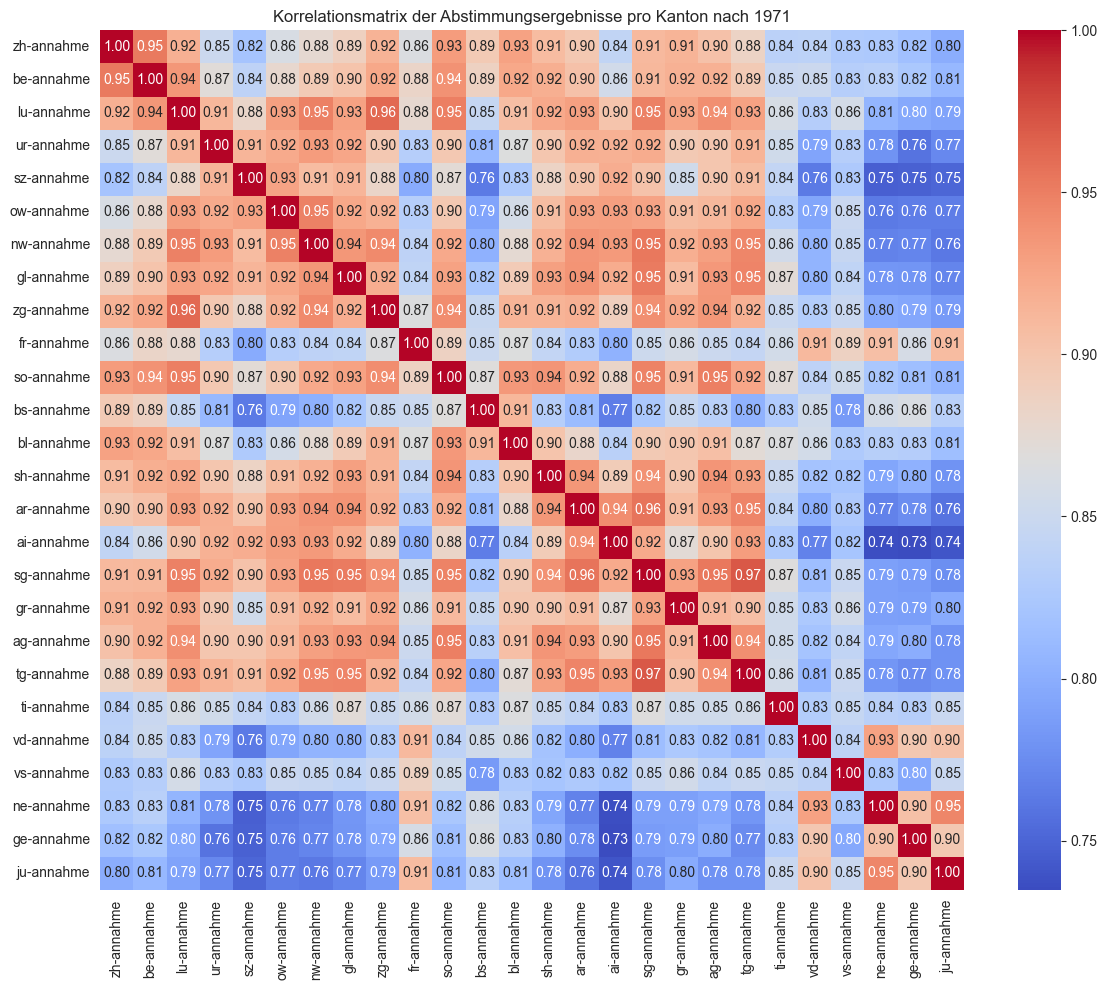

In [10]:
# Abstimmungen nach 1971 (mit Frauenstimmrecht)
df_with_women = df_filtered.loc[pd.to_datetime(df['datum'], format='%d.%m.%Y') > init_date]
df_with_women.reset_index(drop=True, inplace=True)

# Berechne und visualisiere die Korrelationsmatrix für Abstimmungen nach 1971
corr_matrix = df_with_women.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Korrelationsmatrix der Abstimmungsergebnisse pro Kanton nach 1971")
plt.tight_layout()
plt.show()

### Erkenntnisse:
Die Kantone scheinen nach der Abstimmung stärker zu korrelieren.
Ausserdem scheinen eher konservative Kantone wie Uri, Appenzell Innerrhoden und Schwyz sich angeglichen zu haben.
Zudem scheint sich Jura stark an der französischen Schweiz zu orientieren.

## 6. Erweiterte Analyse: Missing-Values-Heatmap

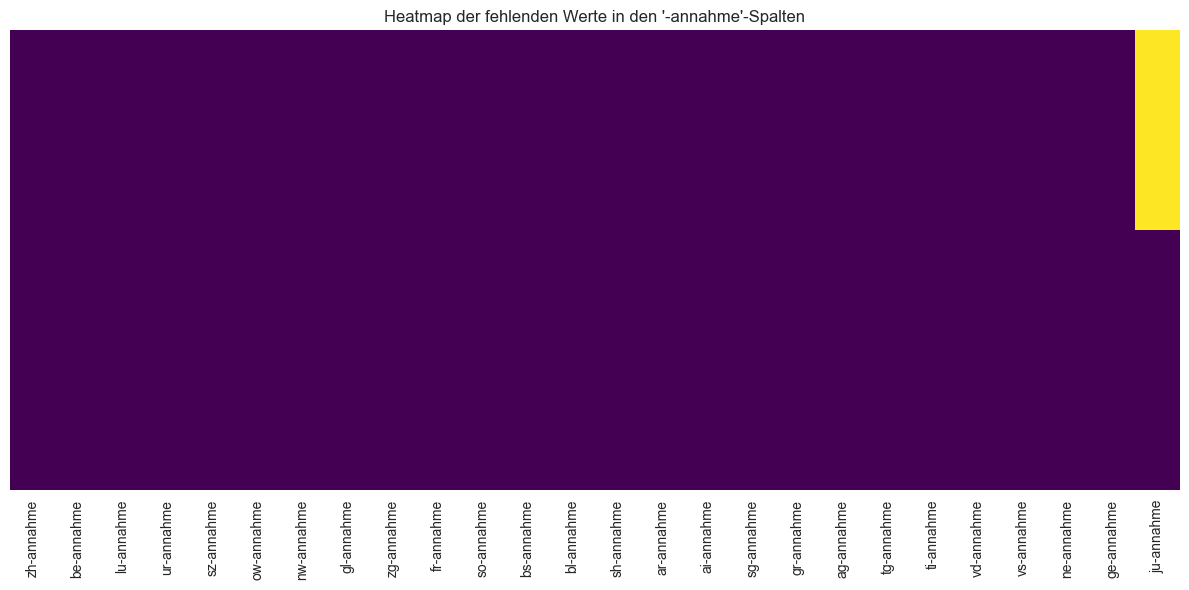

In [11]:
# Visualisiere fehlende Werte in den Abstimmungsdaten pro Kanton
plt.figure(figsize=(12, 6))
sns.heatmap(df_filtered.isna(), cbar=False, yticklabels=False, cmap="viridis")
plt.title("Heatmap der fehlenden Werte in den '-annahme'-Spalten")
plt.tight_layout()
plt.show()

## 7. Analyse der Übereinstimmung zwischen Kantonsstimmen und den Positionen von Ständerat und Nationalrat

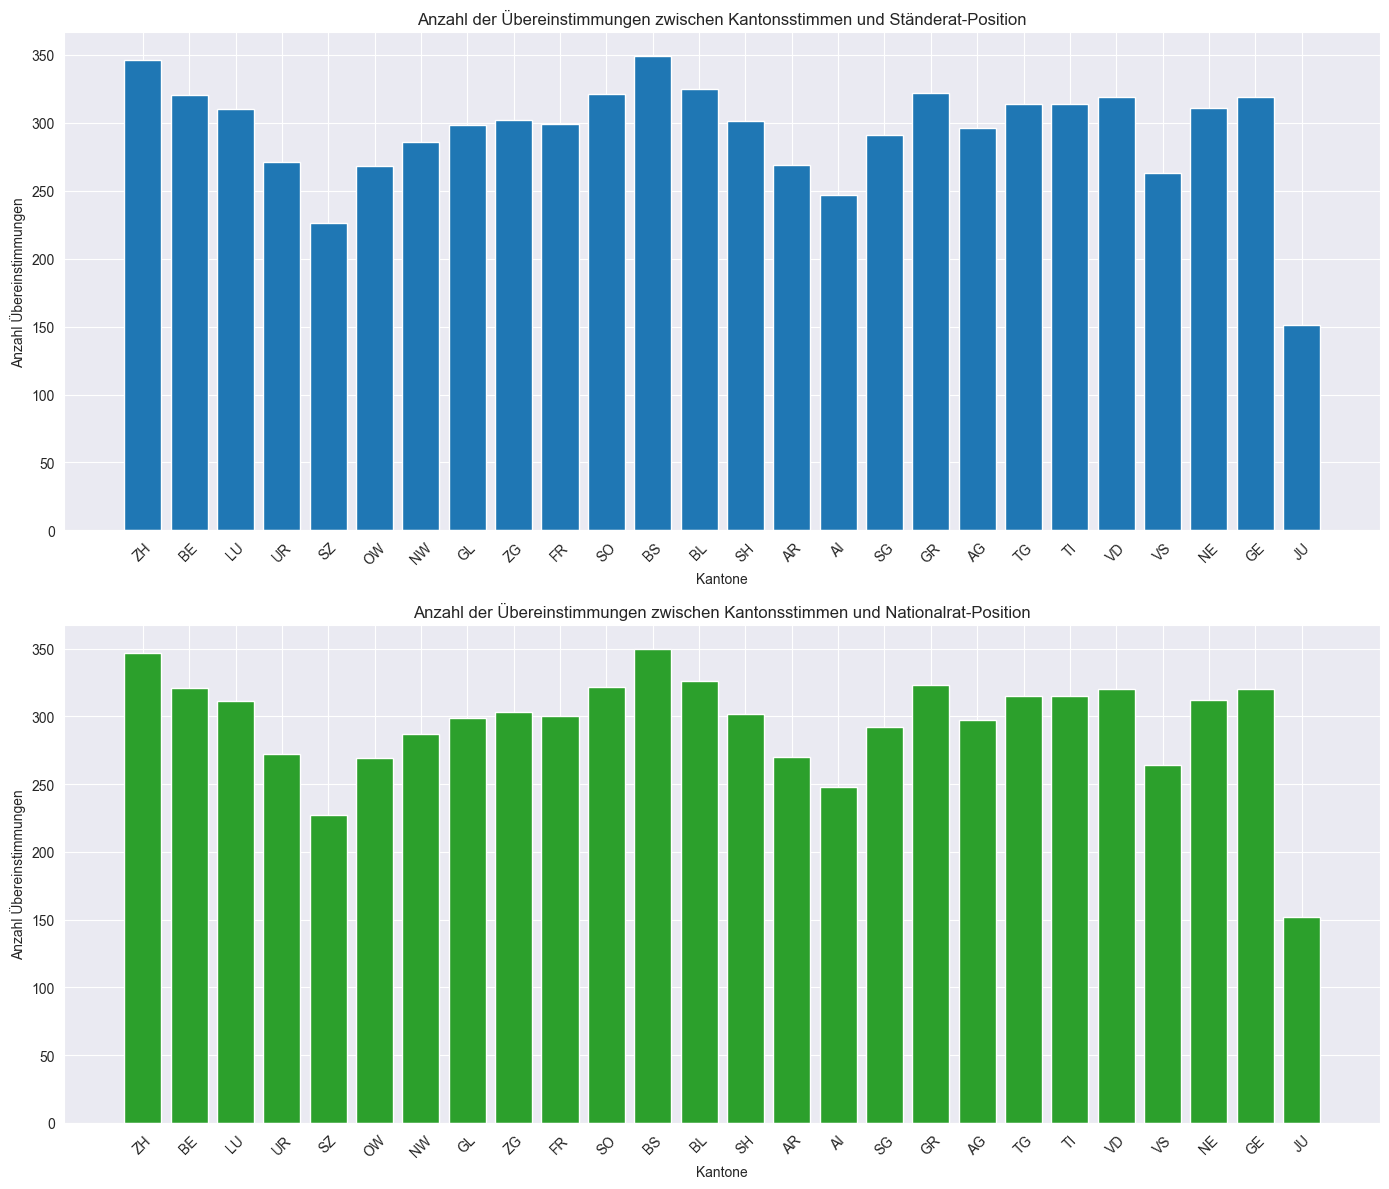

In [12]:
# -------------------------------
# 7. Analyse der Übereinstimmung zwischen Kantonsstimmen und den Positionen von Ständerat und Nationalrat
# -------------------------------

# Bereite die Spalten 'sr-pos' (Ständerat) und 'nr-pos' (Nationalrat) auf
# Wandle problematische Werte um und konvertiere in numerisches Format
df['sr-pos'] = df['sr-pos'].replace({'.': np.nan, 'z': np.nan, '1': 1, '0': 0})
df['nr-pos'] = df['nr-pos'].replace({'.': np.nan, 'z': np.nan, '1': 1, '0': 0})
df['sr-pos'] = pd.to_numeric(df['sr-pos'], errors='coerce')
df['nr-pos'] = pd.to_numeric(df['nr-pos'], errors='coerce')

# Selektiere alle Kantonsspalten für die Analyse
canton_columns = [col for col in df.columns if '-annahme' in col]

# Erstelle leere DataFrames zur Speicherung der Übereinstimmungen
sr_matches = pd.DataFrame(index=df.index)
nr_matches = pd.DataFrame(index=df.index)

# Vergleiche für jeden Kanton, ob dessen Abstimmung mit der Position von Ständerat und Nationalrat übereinstimmt
for canton in canton_columns:
    # Konvertiere die Kantonsstimme in numerisches Format
    canton_vote = pd.to_numeric(df[canton].replace({'.': np.nan, 'z': np.nan, '1': 1, '0': 0}), errors='coerce')
    
    # Prüfe auf Übereinstimmung (True wenn die Stimme mit der Position übereinstimmt)
    sr_matches[canton] = (canton_vote == df['sr-pos'])
    nr_matches[canton] = (canton_vote == df['nr-pos'])

# Berechne die Anzahl der Übereinstimmungen pro Kanton
sr_match_counts = sr_matches.sum(axis=0)
nr_match_counts = nr_matches.sum(axis=0)

# Extrahiere die Kantonsnamen für die Darstellung
canton_names = [col.replace('-annahme', '').upper() for col in canton_columns]

# Erstelle Diagramme für die absolute Anzahl der Übereinstimmungen
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 12))

# Diagramm für Übereinstimmungen mit dem Ständerat
ax1.bar(canton_names, sr_match_counts.values, color='tab:blue')
ax1.set_title('Anzahl der Übereinstimmungen zwischen Kantonsstimmen und Ständerat-Position')
ax1.set_ylabel('Anzahl Übereinstimmungen')
ax1.set_xlabel('Kantone')
ax1.tick_params(axis='x', rotation=45)

# Diagramm für Übereinstimmungen mit dem Nationalrat
ax2.bar(canton_names, nr_match_counts.values, color='tab:green')
ax2.set_title('Anzahl der Übereinstimmungen zwischen Kantonsstimmen und Nationalrat-Position')
ax2.set_ylabel('Anzahl Übereinstimmungen')
ax2.set_xlabel('Kantone')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

### Berechnen und Plotten der Prozentualen Angaben

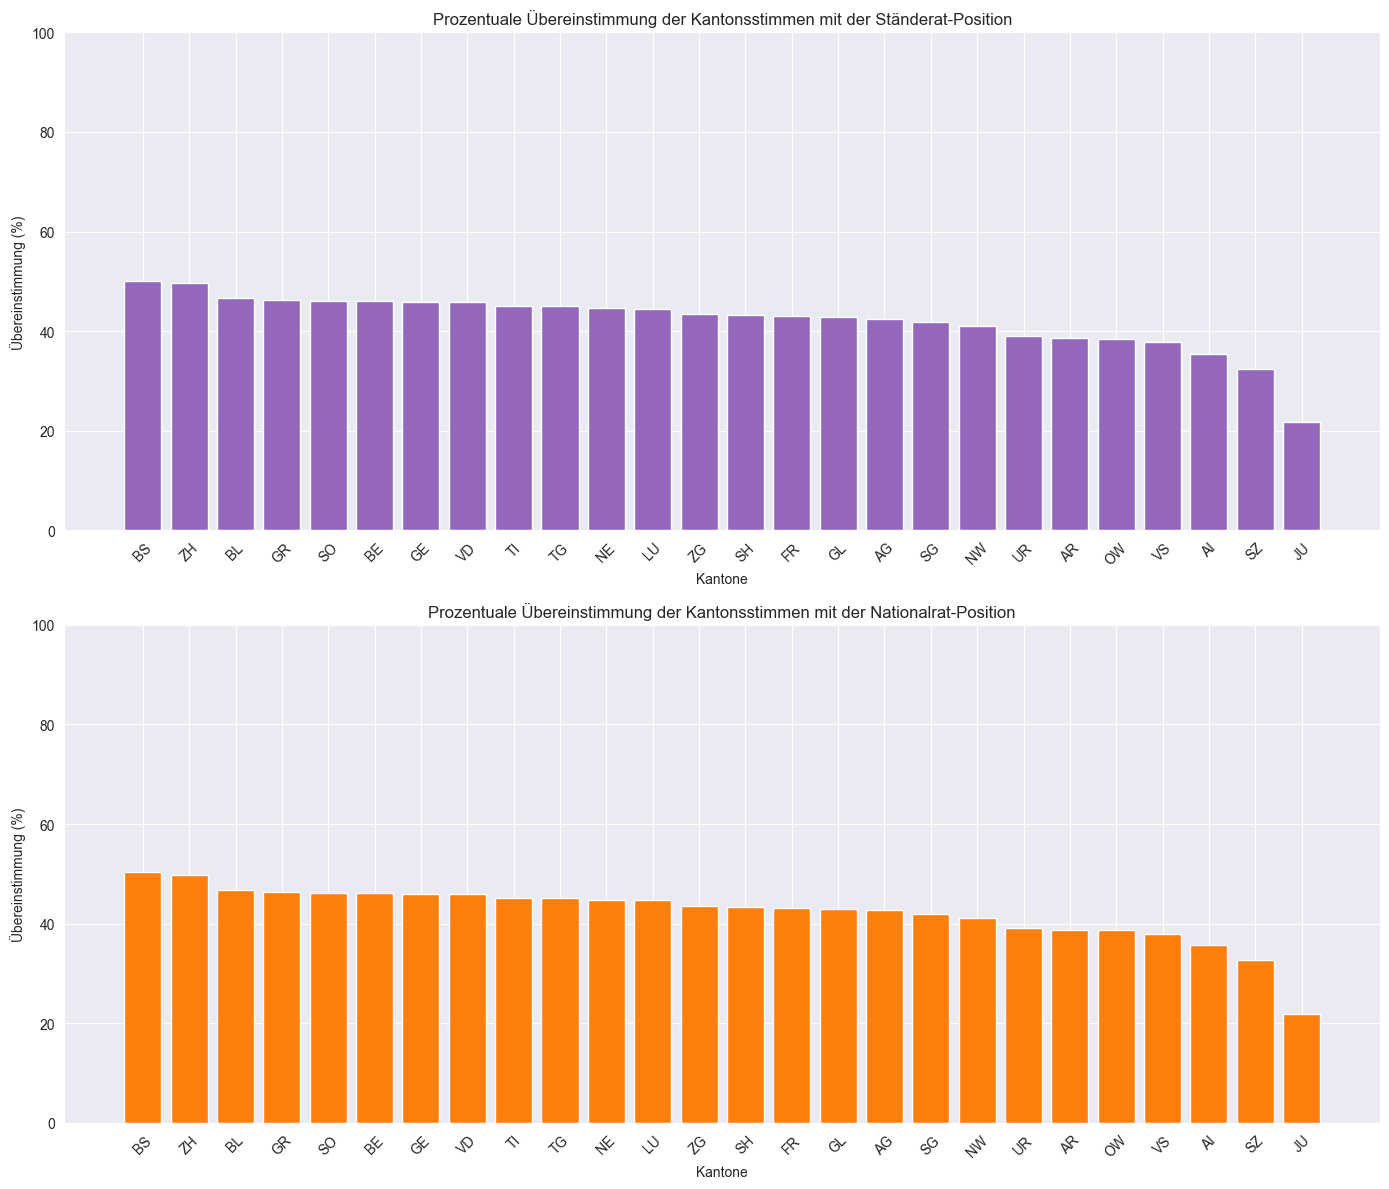

In [13]:
# Berechne den prozentualen Anteil der Übereinstimmungen
total_valid_votes = (~df['sr-pos'].isna()).sum()  # Anzahl gültiger Abstimmungen
sr_match_percentages = (sr_match_counts / total_valid_votes * 100).sort_values(ascending=False)  # Prozentsatz und absteigende Sortierung
nr_match_percentages = (nr_match_counts / total_valid_votes * 100).sort_values(ascending=False)  # Prozentsatz und absteigende Sortierung

# Erstelle Diagramme für die prozentualen Übereinstimmungen
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 12))

# Diagramm für prozentuale Übereinstimmungen mit dem Ständerat
ax1.bar(sr_match_percentages.index.str.replace('-annahme', '').str.upper(),
        sr_match_percentages.values, color='tab:purple')
ax1.set_title('Prozentuale Übereinstimmung der Kantonsstimmen mit der Ständerat-Position')
ax1.set_ylabel('Übereinstimmung (%)')
ax1.set_xlabel('Kantone')
ax1.tick_params(axis='x', rotation=45)
ax1.set_ylim(0, 100)  # Y-Achse von 0 bis 100%

# Diagramm für prozentuale Übereinstimmungen mit dem Nationalrat
ax2.bar(nr_match_percentages.index.str.replace('-annahme', '').str.upper(),
        nr_match_percentages.values, color='tab:orange')
ax2.set_title('Prozentuale Übereinstimmung der Kantonsstimmen mit der Nationalrat-Position')
ax2.set_ylabel('Übereinstimmung (%)')
ax2.set_xlabel('Kantone')
ax2.tick_params(axis='x', rotation=45)
ax2.set_ylim(0, 100)  # Y-Achse von 0 bis 100%

plt.tight_layout()
plt.show()